In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ealaxi/paysim1")

print("Path to dataset files:", path)

100%|██████████| 178M/178M [01:01<00:00, 3.02MB/s] 

Extracting model files...


Path to dataset files: C:\Users\Divya\.cache\kagglehub\datasets\ealaxi\paysim1\versions\2


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.gaussian_process.kernels import RBF
from tmu.models.classification.vanilla_classifier import TMClassifier  # Tsetlin Machine
from scipy.stats import beta
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.tree import ExtraTreeClassifier  # RPTree Classifier (Random Projection-based)
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.sparse import csr_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats import norm

2025-04-05 14:43:03,814 - tensorflow - DEBUG - Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
2025-04-05 14:43:16,717 - h5py._conv - DEBUG - Creating converter from 7 to 5
2025-04-05 14:43:16,720 - h5py._conv - DEBUG - Creating converter from 5 to 7
2025-04-05 14:43:16,724 - h5py._conv - DEBUG - Creating converter from 7 to 5
2025-04-05 14:43:16,726 - h5py._conv - DEBUG - Creating converter from 5 to 7


In [2]:
df=pd.read_csv(r'PS_20174392719_1491204439457_log.csv')

In [3]:
# Encode categorical features
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

# Black-Scholes Risk Model
# Assumes fraud risk follows a financial options pricing model
def black_scholes(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    fraud_risk = norm.cdf(d1) - norm.cdf(d2)
    return fraud_risk

# Feature Engineering
df['balance_change'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['risk_score'] = df['amount'] / (df['oldbalanceOrg'] + 1)
df['risk_score'] = df['risk_score'].apply(lambda x: min(x, 1))
df['fraud_probability'] = beta.cdf(df['risk_score'], a=2, b=5)
df['bs_fraud_risk'] = black_scholes(df['oldbalanceOrg'] + 1, df['amount'] + 1, T=1, r=0.05, sigma=0.3)

df = df.sort_values(by='step', ascending=False)  # Assuming 'step' represents time
df_fraud = df[df['isFraud'] == 1]
df_non_fraud = df[df['isFraud'] == 0]
non_fraud_sample_size = min(len(df_fraud) * 5, len(df_non_fraud))  # Control downsampling ratio
df_non_fraud_sampled = df_non_fraud.head(non_fraud_sample_size)  # Keep recent non-fraud samples
df_sampled = pd.concat([df_fraud, df_non_fraud_sampled]).sample(frac=1, random_state=42)  # Shuffle

df = df_sampled

In [4]:
# Prepare data
features = ['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'balance_change', 'risk_score', 'fraud_probability', 'bs_fraud_risk']
X = df[features]
y = df['isFraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# Feature Selection to Reduce Dimensionality
selector = SelectKBest(score_func=f_classif, k=min(10, X_train.shape[1]))
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

In [6]:
# Hybrid Variational Autoencoder in TensorFlow
def build_hybrid_vae(input_dim, latent_dim=8):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(32, activation='relu')(inputs)
    x = layers.Dense(16, activation='relu')(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    
    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    
    encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
    
    latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Dense(16, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(input_dim, activation='sigmoid')(x)
    decoder = keras.Model(latent_inputs, outputs, name='decoder')
    
    outputs = decoder(encoder(inputs)[2])
    vae = keras.Model(inputs, outputs, name='vae')
    
    reconstruction_loss = tf.keras.losses.MeanSquaredError()(inputs, outputs)
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    vae_loss = reconstruction_loss + kl_loss
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    
    return vae, encoder, decoder

vae, encoder, decoder = build_hybrid_vae(X_train.shape[1])
vae.fit(X_train, X_train, epochs=20, batch_size=64, verbose=1)
X_train_encoded = encoder.predict(X_train)[0]
X_test_encoded = encoder.predict(X_test)[0]

Epoch 1/20


616/616 [==============================] - 6s 4ms/step - loss: 1.0121
Epoch 2/20
616/616 [==============================] - 2s 3ms/step - loss: 0.9356
Epoch 3/20
616/616 [==============================] - 2s 4ms/step - loss: 0.9262
Epoch 4/20
616/616 [==============================] - 2s 3ms/step - loss: 0.9180
Epoch 5/20
616/616 [==============================] - 2s 3ms/step - loss: 0.9126
Epoch 6/20
616/616 [==============================] - 1s 2ms/step - loss: 0.9096
Epoch 7/20
616/616 [==============================] - 2s 3ms/step - loss: 0.9081
Epoch 8/20
616/616 [==============================] - 2s 3ms/step - loss: 0.9070
Epoch 9/20
616/616 [==============================] - 2s 3ms/step - loss: 0.9066
Epoch 10/20
616/616 [==============================] - 1s 2ms/step - loss: 0.9050
Epoch 11/20
616/616 [==============================] - 2s 3ms/step - loss: 0.9028
Epoch 12/20
616/616 [==============================] - 1s 2ms/step - loss: 0.9020
Epoch 13/20
616/616 [===============

In [7]:
# Scalable Nyström Approximation-based Gaussian Process
n_components = min(100, X_train_encoded.shape[0] // 1000)  # Reduce components for scalability
nystroem = Nystroem(kernel='rbf', gamma=0.5, n_components=n_components)
X_train_nys = csr_matrix(nystroem.fit_transform(X_train_encoded))  # Convert to sparse matrix
X_test_nys = csr_matrix(nystroem.transform(X_test_encoded))

# Using Mini-batch SGD for scalability with balanced class weights
gpc_approx = SGDClassifier(loss='log', class_weight='balanced', penalty='elasticnet', l1_ratio=0.15, random_state=42, max_iter=1000, tol=1e-3)
gpc_approx.fit(X_train_nys, y_train)
y_pred_gpc_approx = gpc_approx.predict(X_test_nys)


In [8]:
# RPTree Classifier (Random Projection-based)
rptree = ExtraTreeClassifier(random_state=42)
rptree.fit(X_train, y_train)
y_pred_rptree = rptree.predict(X_test)


In [10]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"{model_name} - Accuracy: {accuracy_score(y_true, y_pred):.4f}, F1 Score: {f1_score(y_true, y_pred):.4f}, Precision: {precision_score(y_true, y_pred):.4f}, Recall: {recall_score(y_true, y_pred):.4f}")

evaluate_model(y_test, y_pred_gpc_approx, "GPC")
evaluate_model(y_test, y_pred_rptree, "RPTree")

GPC - Accuracy: 0.9704, F1 Score: 0.9196, Precision: 0.8556, Recall: 0.9941
RPTree - Accuracy: 0.9981, F1 Score: 0.9944, Precision: 0.9935, Recall: 0.9952


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Define GRU Model
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    GRU(32),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train.reshape(-1, X_train.shape[1], 1), y_train, epochs=10, batch_size=128, verbose=1)

# Predictions
y_pred_gru = model.predict(X_test.reshape(-1, X_test.shape[1], 1))
y_pred_gru = (y_pred_gru > 0.5).astype(int)


Epoch 1/10
308/308 [==============================] - 9s 13ms/step - loss: 0.1057 - accuracy: 0.9677
Epoch 2/10
308/308 [==============================] - 5s 16ms/step - loss: 0.0534 - accuracy: 0.9813
Epoch 3/10
308/308 [==============================] - 4s 14ms/step - loss: 0.0488 - accuracy: 0.9834
Epoch 4/10
308/308 [==============================] - 4s 13ms/step - loss: 0.0453 - accuracy: 0.9857
Epoch 5/10
308/308 [==============================] - 4s 13ms/step - loss: 0.0405 - accuracy: 0.9878
Epoch 6/10
308/308 [==============================] - 4s 13ms/step - loss: 0.0407 - accuracy: 0.9876
Epoch 7/10
308/308 [==============================] - 4s 13ms/step - loss: 0.0386 - accuracy: 0.9885
Epoch 8/10
308/308 [==============================] - 4s 13ms/step - loss: 0.0376 - accuracy: 0.9888
Epoch 9/10
308/308 [==============================] - 4s 13ms/step - loss: 0.0364 - accuracy: 0.9893
Epoch 10/10
308/308 [==============================] - 1s 3ms/step


In [12]:
evaluate_model(y_test, y_pred_gru, "GRU")

GRU - Accuracy: 0.9919, F1 Score: 0.9763, Precision: 0.9717, Recall: 0.9810


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from scipy.stats import beta, entropy
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Initialize Bayesian reliability scores (Alpha = correct, Beta = incorrect)
model_performance = {
    "GRU": [1, 1],  # (Alpha, Beta)
    "GPC": [1, 1],
    "RPTree": [1, 1]
}

# Global variable to store past correctness scores
past_correctness_scores = []

# Function to update correctness scores and Bayesian reliability
def update_correctness_scores(y_true, y_preds):
    global past_correctness_scores, model_performance

    # Ensure all arrays are flattened 1D (9856,)
    y_true = np.array(y_true).flatten()
    pred_gru = np.array(y_preds["GRU"]).flatten()
    pred_gpc = np.array(y_preds["GPC"]).flatten()
    pred_rptree = np.array(y_preds["RPTree"]).flatten()

    # Element-wise correctness check
    correctness = np.array([
        np.mean(pred_gru == y_true),    # Fraction of correct predictions for GRU
        np.mean(pred_gpc == y_true),    # Fraction of correct predictions for GPC
        np.mean(pred_rptree == y_true)  # Fraction of correct predictions for RPTree
    ])

    past_correctness_scores.append(correctness)

    # Keep only last 10 scores for GRU trend modeling
    if len(past_correctness_scores) > 10:
        past_correctness_scores.pop(0)

    # Bayesian update: successes increase alpha, failures increase beta
    for i, model in enumerate(["GRU", "GPC", "RPTree"]):
        model_performance[model][0] += correctness[i]  # Alpha update
        model_performance[model][1] += (1 - correctness[i])  # Beta update


# Compute Bayesian model weights (expected reliability)
def compute_bayesian_weights():
    weights = {}
    for model, (alpha, beta_val) in model_performance.items():
        weights[model] = alpha / (alpha + beta_val)  # Expected value of Beta distribution
    return weights

# Compute entropy-based confidence scores
def compute_entropy_weights(y_preds):
    
    pred_gru = np.array(y_preds["GRU"]).reshape(-1, 1)
    pred_gpc = np.array(y_preds["GPC"]).reshape(-1, 1)
    pred_rptree = np.array(y_preds["RPTree"]).reshape(-1, 1)
    
    min_len = min(len(pred_gru), len(pred_gpc), len(pred_rptree))
    pred_gru, pred_gpc, pred_rptree = pred_gru[:min_len], pred_gpc[:min_len], pred_rptree[:min_len]

    
    prob_matrix = np.hstack([pred_gru, pred_gpc, pred_rptree])  # Shape (N, 3)
    return np.exp(-entropy(prob_matrix.T, base=2))  # Lower entropy means higher confidence

# Compute final fraud probability
def compute_final_fraud_probability(y_preds, y_true):
    bayesian_weights = compute_bayesian_weights()  # Shape: (3,)
    entropy_weights = compute_entropy_weights(y_preds)  # Shape: (9856,)

    # Expand `bayesian_weights` to match shape (9856, 3)
    combined_weights = np.array([bayesian_weights["GRU"], bayesian_weights["GPC"], bayesian_weights["RPTree"]])
    final_weights = combined_weights * entropy_weights[:, np.newaxis]  # Shape: (9856, 3)
    final_weights /= final_weights.sum(axis=1, keepdims=True)  # Normalize per row

    # Ensure all predictions are 1D arrays of shape (9856,)
    pred_gru = np.array(y_preds["GRU"]).flatten()
    pred_gpc = np.array(y_preds["GPC"]).flatten()
    pred_rptree = np.array(y_preds["RPTree"]).flatten()

    # Stack correctly (Shape: (9856, 3))
    pred_matrix = np.column_stack([pred_gru, pred_gpc, pred_rptree])  # (9856, 3)

    # Compute weighted sum
    final_prediction = np.sum(pred_matrix * final_weights, axis=1)  # (9856,)

    # Convert to binary (0 or 1)
    final_prediction = (final_prediction > 0.5).astype(int)

    # Update correctness scores
    update_correctness_scores(y_true, y_preds)

    return final_prediction

In [14]:
# Evaluate the final fusion model
def evaluate_fusion(y_test, final_pred):
    print(f"Fusion Model - Accuracy: {accuracy_score(y_test, final_pred):.4f}, "
        f"F1 Score: {f1_score(y_test, final_pred):.4f}, "
        f"Precision: {precision_score(y_test, final_pred):.4f}, "
        f"Recall: {recall_score(y_test, final_pred):.4f}")

# Predict using GRU, GPC, and RPTree (Assuming predictions exist in variables)
y_preds = {"GRU": y_pred_gru, "GPC": y_pred_gpc_approx, "RPTree": y_pred_rptree}
final_pred = compute_final_fraud_probability(y_preds, y_test)
evaluate_fusion(y_test, final_pred)

Fusion Model - Accuracy: 0.9939, F1 Score: 0.9824, Precision: 0.9709, Recall: 0.9941


c:\Users\Divya\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2664: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


In [15]:
y_train_pred_gpc_approx = gpc_approx.predict(X_train_nys)
y_test_pred_rptree = rptree.predict(X_train)
y_test_pred_gru = model.predict(X_train.reshape(-1, X_test.shape[1], 1))

1232/1232 [==============================] - 4s 3ms/step


In [16]:
y_train_preds = {"GRU": y_test_pred_gru, "GPC": y_train_pred_gpc_approx, "RPTree": y_test_pred_rptree}
final_train_pred = compute_final_fraud_probability(y_train_preds, y_train)
evaluate_fusion(y_train, final_train_pred)

Fusion Model - Accuracy: 0.9925, F1 Score: 0.9777, Precision: 0.9618, Recall: 0.9942


In [17]:
evaluate_fusion(y_test, final_pred)

Fusion Model - Accuracy: 0.9939, F1 Score: 0.9824, Precision: 0.9709, Recall: 0.9941


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
def monte_carlo_simulation(model, X_test, X_test_nys,base_rate_range=np.linspace(0.001, 0.5, 25), runs=100):
    results = []

    for base_rate in base_rate_range:
        metrics = []
        for _ in range(runs):
            # Create synthetic balanced dataset
            n = len(X_test)
            fraud_size = int(n * base_rate)
            legit_size = n - fraud_size

            y_synthetic = np.array([1]*fraud_size + [0]*legit_size)
            np.random.shuffle(y_synthetic)
            
            y_test_pred_gpc_approx = gpc_approx.predict(X_test_nys)
            y_test_pred_rptree = rptree.predict(X_test)
            y_test_pred_gru = model.predict(X_test.reshape(-1, X_test.shape[1], 1))

            y_test_preds = {"GRU": y_test_pred_gru, "GPC": y_test_pred_gpc_approx, "RPTree": y_test_pred_rptree}
            
            preds = compute_final_fraud_probability(y_test_preds, y_test)
            auc_sim = roc_curve(y_synthetic, preds)
            metrics.append(auc_sim)

        results.append(np.mean(metrics))

    plt.figure(figsize=(10, 6))
    plt.plot(base_rate_range, results, marker='o')
    plt.xlabel("Simulated Fraud Rate")
    plt.ylabel("Average AUC Score")
    plt.title("Monte Carlo Simulation of Model under Varying Fraud Rates")
    plt.grid(True)
    plt.show()


308/308 [==============================] - 6s 18ms/step
2025-04-05 21:36:58,589 - matplotlib.font_manager - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2025-04-05 21:36:58,608 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
2025-04-05 21:36:58,615 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
2025-04-05 21:36:58,618 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
2025-04-05 21:36:58,621 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 1.335
2025-04-05 21:36:58,624 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335
2025-04-05 21:36:5

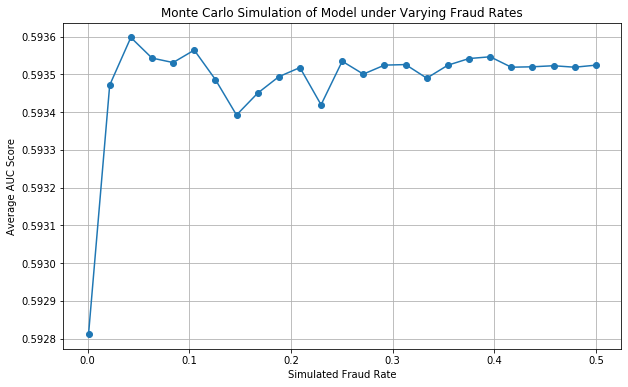

In [33]:
monte_carlo_simulation(model, X_test,X_test_nys)

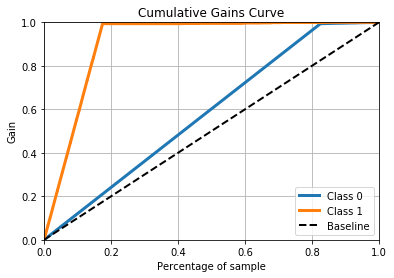

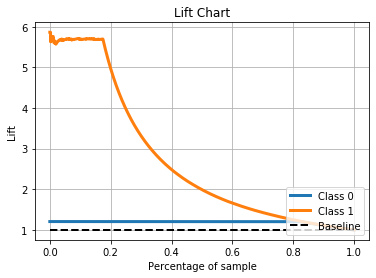

In [47]:
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve

y_probas = np.vstack([1 - final_pred, final_pred]).T

plot_cumulative_gain(y_test, y_probas)
plt.title("Cumulative Gains Curve")
plt.show()

plot_lift_curve(y_test, y_probas)
plt.title("Lift Chart")
plt.show()


In [40]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_test, final_pred)
print("Matthews Correlation Coefficient (MCC):", round(mcc, 4))
from sklearn.metrics import brier_score_loss

brier = brier_score_loss(y_test, final_pred)
print("Brier Score:", round(brier, 4))


Matthews Correlation Coefficient (MCC): 0.9788
Brier Score: 0.0061


In [44]:
from sklearn.metrics import log_loss

logloss = log_loss(y_test, final_pred)
print("Log Loss:", round(logloss, 4))


Log Loss: 0.2103


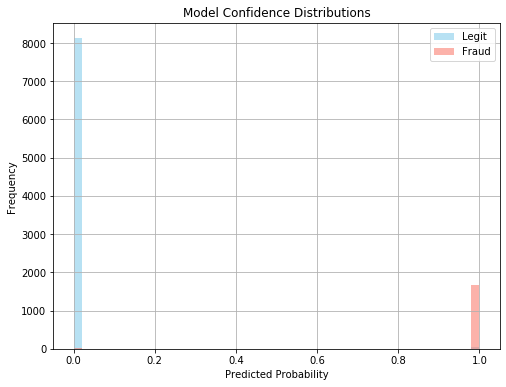

In [43]:
plt.figure(figsize=(8, 6))
plt.hist(final_pred[y_test == 0], bins=50, alpha=0.6, label="Legit", color="skyblue")
plt.hist(final_pred[y_test == 1], bins=50, alpha=0.6, label="Fraud", color="salmon")
plt.title("Model Confidence Distributions")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


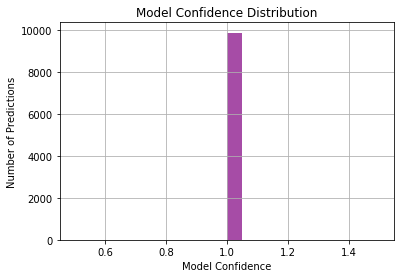

In [45]:
import matplotlib.pyplot as plt

# Assuming `y_proba` is the predicted probability of fraud
# Confidence = max(probability of the predicted class)
confidence = np.maximum(final_pred, 1 - final_pred)

plt.hist(confidence, bins=20, color='purple', alpha=0.7)
plt.xlabel('Model Confidence')
plt.ylabel('Number of Predictions')
plt.title('Model Confidence Distribution')
plt.grid(True)
plt.show()


In [48]:
import pandas as pd
import numpy as np

# Assuming final_pred contains the predicted probabilities for class 1 (fraud)
# y_test contains the true labels (0: legit, 1: fraud)
df_conf = pd.DataFrame({
    'y_true': y_test,
    'y_prob': final_pred
})

# Define confidence bins
bins = [0.0, 0.6, 0.9, 1.0]
labels = ['Low', 'Medium', 'High']
df_conf['confidence_bin'] = pd.cut(df_conf['y_prob'], bins=bins, labels=labels)

# Compute metrics by confidence bin
summary = df_conf.groupby('confidence_bin').apply(
    lambda x: pd.Series({
        'Total': len(x),
        'Fraud Count': x['y_true'].sum(),
        'Accuracy': ((x['y_prob'] > 0.5) == x['y_true']).mean(),
        'Fraud %': x['y_true'].mean() * 100
    })
).reset_index()

print(summary)


  confidence_bin   Total  Fraud Count  Accuracy    Fraud %
0            Low     0.0          0.0       NaN        NaN
1         Medium     0.0          0.0       NaN        NaN
2           High  1721.0       1671.0  0.970947  97.094712


In [49]:
# Combine predictions and ground truth
df_topk = pd.DataFrame({
    'y_true': y_test,
    'y_prob': final_pred
})

# Sort by highest predicted fraud probability
df_topk_sorted = df_topk.sort_values(by='y_prob', ascending=False)

# Evaluate Top-K
top_k_list = [50, 100, 500, 1000]
results = []

for k in top_k_list:
    topk = df_topk_sorted.head(k)
    frauds_found = topk['y_true'].sum()
    precision = frauds_found / k
    results.append((k, frauds_found, precision))

df_topk_results = pd.DataFrame(results, columns=['Top-K', 'Fraud Captured', 'Precision'])
print(df_topk_results)


   Top-K  Fraud Captured  Precision
0     50              50      1.000
1    100              97      0.970
2    500             489      0.978
3   1000             972      0.972


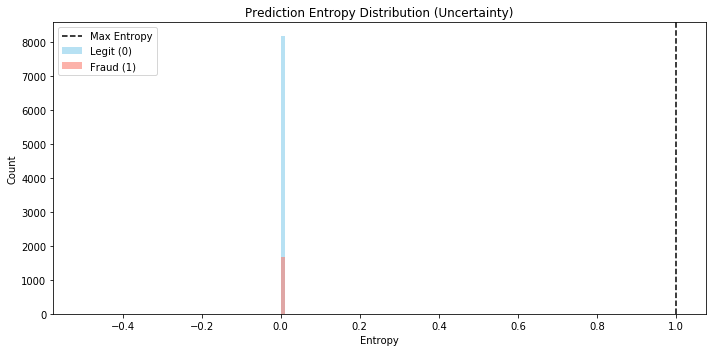

In [50]:
from scipy.stats import entropy
import matplotlib.pyplot as plt

# Assuming you have 2-class probabilities (e.g., output of model.predict_proba())
# final_proba[:, 0] is for class 0, final_proba[:, 1] for class 1
# If you only have predicted prob for class 1, compute for binary:
probs = np.vstack([1 - final_pred, final_pred]).T

# Calculate entropy per prediction (base 2)
entropy_values = [entropy(p, base=2) for p in probs]

# Create DataFrame
df_entropy = pd.DataFrame({
    'y_true': y_test,
    'predicted_proba': final_pred,
    'entropy': entropy_values
})

# Plot entropy distributions
plt.figure(figsize=(10, 5))
plt.hist(df_entropy[df_entropy['y_true'] == 0]['entropy'], bins=100, alpha=0.6, label='Legit (0)', color='skyblue')
plt.hist(df_entropy[df_entropy['y_true'] == 1]['entropy'], bins=100, alpha=0.6, label='Fraud (1)', color='salmon')
plt.axvline(x=1.0, linestyle='--', color='black', label='Max Entropy')
plt.title("Prediction Entropy Distribution (Uncertainty)")
plt.xlabel("Entropy")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


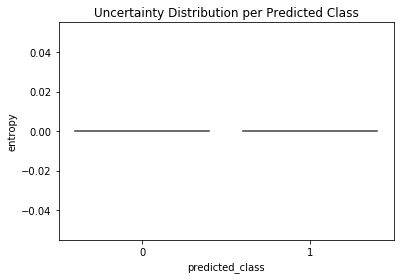

In [51]:
import seaborn as sns

df_entropy['predicted_class'] = (df_entropy['predicted_proba'] > 0.5).astype(int)
sns.violinplot(data=df_entropy, x='predicted_class', y='entropy')
plt.title("Uncertainty Distribution per Predicted Class")
plt.show()


In [52]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss

# Use predicted probs and true labels
X_for_platt = final_pred.reshape(-1, 1)  # predicted probs as features
y_for_platt = y_test                    # actual test labels

# Fit Platt Scaling (logistic calibration)
platt_model = LogisticRegression()
platt_model.fit(X_for_platt, y_for_platt)

# Apply sigmoid calibration
calibrated_model = CalibratedClassifierCV(base_estimator=platt_model, method='sigmoid', cv='prefit')
calibrated_model.fit(X_for_platt, y_for_platt)

# Get calibrated probabilities
calibrated_probs = calibrated_model.predict_proba(X_for_platt)[:, 1]

# Evaluate calibration
print("Original Brier Score:", brier_score_loss(y_for_platt, final_pred))
print("Calibrated Brier Score:", brier_score_loss(y_for_platt, calibrated_probs))


Original Brier Score: 0.006087662337662338
Calibrated Brier Score: 0.005939097941643859


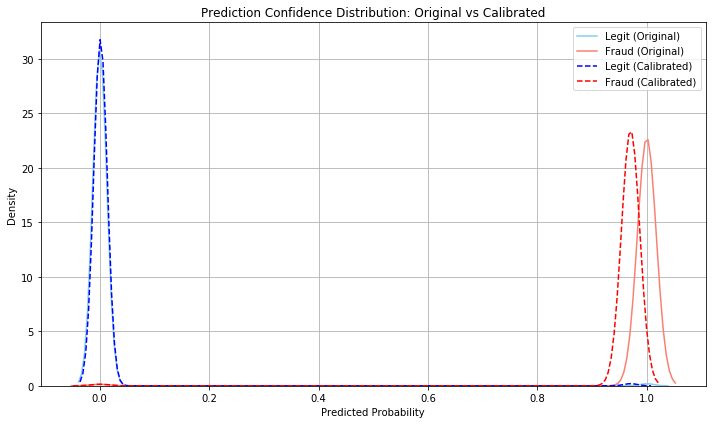

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create dataframe
df = pd.DataFrame({
    'True Label': y_test,
    'Original': final_pred,
    'Calibrated': calibrated_probs
})

# Plot density curves for original vs calibrated probs
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['True Label'] == 0]['Original'], label='Legit (Original)', color='skyblue')
sns.kdeplot(df[df['True Label'] == 1]['Original'], label='Fraud (Original)', color='salmon')
sns.kdeplot(df[df['True Label'] == 0]['Calibrated'], linestyle='--', label='Legit (Calibrated)', color='blue')
sns.kdeplot(df[df['True Label'] == 1]['Calibrated'], linestyle='--', label='Fraud (Calibrated)', color='red')
plt.title("Prediction Confidence Distribution: Original vs Calibrated")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


2025-04-03 01:02:48,757 - matplotlib - DEBUG - $HOME=C:\Users\Divya
2025-04-03 01:02:52,797 - matplotlib - DEBUG - CONFIGDIR=C:\Users\Divya\.matplotlib
2025-04-03 01:02:52,807 - matplotlib - DEBUG - matplotlib data path: c:\Users\Divya\anaconda3\lib\site-packages\matplotlib\mpl-data
2025-04-03 01:02:54,934 - matplotlib - DEBUG - loaded rc file c:\Users\Divya\anaconda3\lib\site-packages\matplotlib\mpl-data\matplotlibrc
2025-04-03 01:02:56,158 - matplotlib - DEBUG - matplotlib version 3.1.3
2025-04-03 01:02:56,169 - matplotlib - DEBUG - interactive is False
2025-04-03 01:02:56,185 - matplotlib - DEBUG - platform is win32
2025-04-03 01:03:03,316 - matplotlib - DEBUG - loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'nt', 'winreg', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', 'site', '

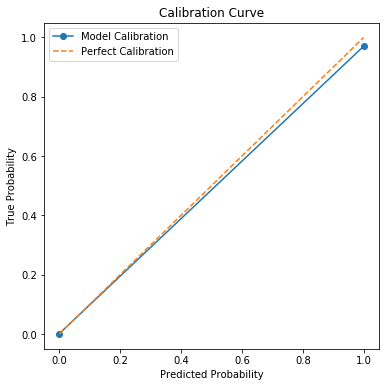

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

def plot_calibration_curve(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    
    plt.figure(figsize=(6,6))
    plt.plot(prob_pred, prob_true, marker='o', label="Model Calibration")
    plt.plot([0, 1], [0, 1], linestyle='--', label="Perfect Calibration")
    plt.xlabel("Predicted Probability")
    plt.ylabel("True Probability")
    plt.legend()
    plt.title("Calibration Curve")
    plt.show()

plot_calibration_curve(y_test,final_pred)

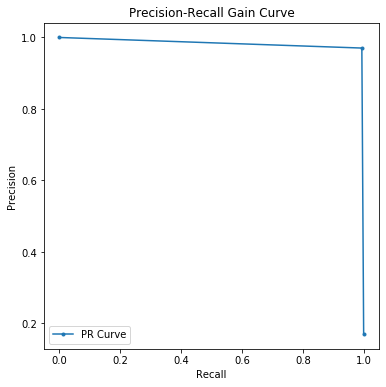

In [50]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

def plot_pr_gain(y_true, y_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    
    plt.figure(figsize=(6,6))
    plt.plot(recall, precision, marker='.', label="PR Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Gain Curve")
    plt.legend()
    plt.show()

plot_pr_gain(y_test,final_pred)

2025-04-03 01:21:15,949 - matplotlib.colorbar - DEBUG - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000219AB6CD088>
2025-04-03 01:21:15,952 - matplotlib.colorbar - DEBUG - Using auto colorbar locator on colorbar
2025-04-03 01:21:15,955 - matplotlib.colorbar - DEBUG - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000219AB6CD088>
2025-04-03 01:21:15,957 - matplotlib.colorbar - DEBUG - Setting pcolormesh


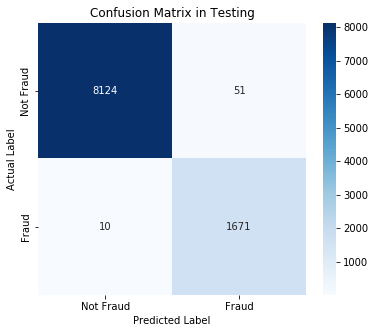

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title("Confusion Matrix in Testing")
    plt.show()

labels = ["Not Fraud", "Fraud"]

plot_confusion_matrix(y_test,final_pred,labels=labels)

In [65]:
# Monte Carlo Simulation Parameters
num_simulations = 1000
fraud_rates = np.linspace(0.001, 0.1, 50)  # Simulating fraud rates from 0.1% to 10%
model_f1_scores = []

for rate in fraud_rates:
    # Adjusting dataset fraud rate dynamically
    fraud_cases = df[df['isFraud'] == 1].sample(frac=rate, replace=True)
    non_fraud_cases = df[df['isFraud'] == 0].sample(frac=1-rate, replace=True)
    new_sample = pd.concat([fraud_cases, non_fraud_cases])
    
    # Splitting and making predictions
    X_new = new_sample.drop(columns=['isFraud'])
    y_new = new_sample['isFraud']
    
    y_gpc_approx = gpc_approx.predict(X_new)
    y_rptree = rptree.predict(X_new)
    y_gru = model.predict(X_new.reshape(-1, X_new.shape[1], 1))
    y = {"GRU": y_gru, "GPC": y_gpc_approx, "RPTree": y_rptree}
    final = compute_final_fraud_probability(y, y_new)
    
    # Calculating F1-score
    f1 = f1_score(y_new, final)
    model_f1_scores.append(f1)

# Plot Monte Carlo results
plt.figure(figsize=(8, 5))
plt.plot(fraud_rates * 100, model_f1_scores, marker='o', linestyle='-')
plt.xlabel('Fraud Rate (%)')
plt.ylabel('F1 Score')
plt.title('Monte Carlo Simulation: Model Stability Under Varying Fraud Rates')
plt.grid()
plt.show()

c:\Users\Divya\anaconda3\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


ValueError: could not convert string to float: 'C2029948339'

In [60]:
y_new.shape

(41032,)

In [64]:
final.shape

(39422,)